In [1]:
import os
import vulncheck_sdk
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import pandas as pd

DEFAULT_HOST = "https://api.vulncheck.com"
DEFAULT_API = DEFAULT_HOST + "/v3"
# TOKEN = "INSERT_TOKEN_HERE"  # Replace with your actual API token
TOKEN = os.environ["VULNCHECK_API_TOKEN"]

# Configure the VulnCheck API client
configuration = vulncheck_sdk.Configuration(host=DEFAULT_API)
configuration.api_key["Bearer"] = TOKEN

## Pull Data From VulnCheck Exploits Index

In [2]:
with vulncheck_sdk.ApiClient(configuration) as api_client:
    indices_client = vulncheck_sdk.IndicesApi(api_client)

    limit=2000

    # Initialize lists to store vendor and CVE data
    cve = []
    exploits = []
    nvd_published_date = []
    vulncheck_kev_date_added = []

    # Make the initial request to start pagination
    api_response = indices_client.index_exploits_get(start_cursor="true", limit=limit)

   # Process the the results
for entry in api_response.data:
    cve.append(entry.id)
    exploits.append(entry.counts.exploits)
    nvd_published_date.append(entry.timeline.nvd_published[:10] if entry.timeline.nvd_published else None)
    vulncheck_kev_date_added.append(entry.timeline.vulncheck_kev_date_added[:10] if entry.timeline.vulncheck_kev_date_added else None)
    
while api_response.meta.next_cursor is not None:

    api_response = indices_client.index_exploits_get(
        cursor=api_response.meta.next_cursor, limit=limit
    )

    for entry in api_response.data:
        cve.append(entry.id)
        exploits.append(entry.counts.exploits)
        nvd_published_date.append(entry.timeline.nvd_published[:10] if entry.timeline.nvd_published else None)
        vulncheck_kev_date_added.append(entry.timeline.vulncheck_kev_date_added[:10] if entry.timeline.vulncheck_kev_date_added else None)

# Create a DataFrame
df = pd.DataFrame({
    'CVE': cve,
    '# of Exploits': exploits,
    "NVD Published Date": nvd_published_date,
    "VulnCheck KEV Added Date": vulncheck_kev_date_added
})



## 2023 Time from CVE disclosure to Exploitation

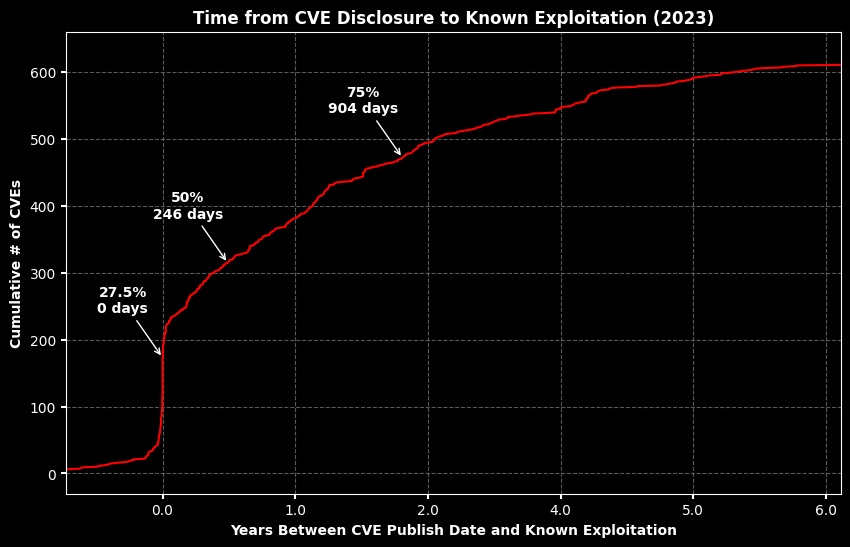

In [3]:
# Ensure date columns are in datetime format
df['NVD Published Date'] = pd.to_datetime(df['NVD Published Date'], errors='coerce')
df['VulnCheck KEV Added Date'] = pd.to_datetime(df['VulnCheck KEV Added Date'], errors='coerce')

# Filter for rows where the VulnCheck KEV Added Date is in 2023
df_2023 = df[df['VulnCheck KEV Added Date'].dt.year == 2023].copy()

# Calculate the number of days between the two dates
df_2023.loc[:, 'Days Between'] = (df_2023['VulnCheck KEV Added Date'] - df_2023['NVD Published Date']).dt.days

# Drop rows where 'Days Between' is NaN (either date is missing)
df_2023 = df_2023.dropna(subset=['Days Between'])

# Sort by the 'Days Between' to prepare for cumulative counting
df_2023 = df_2023.sort_values(by='Days Between').reset_index(drop=True)

# Create a cumulative count of CVEs
df_2023['Cumulative CVEs'] = df_2023.index + 1

# Calculate the percentage of CVEs with 'Days Between' <= 0
percent_zero_or_less = (df_2023[df_2023['Days Between'] <= 0].shape[0] / df_2023.shape[0]) * 100
days_zero_or_less = 0  # Days for the <= 0 group

# Calculate 50% and 75% cumulative CVE count values
cve_50 = df_2023['Cumulative CVEs'].max() * 0.50
cve_75 = df_2023['Cumulative CVEs'].max() * 0.75

# Find the corresponding day values closest to these cumulative markers
days_50 = df_2023[df_2023['Cumulative CVEs'] >= cve_50].iloc[0]['Days Between']
days_75 = df_2023[df_2023['Cumulative CVEs'] >= cve_75].iloc[0]['Days Between']

# Set up dark mode for the plot
plt.style.use('dark_background')

# Plot the cumulative count with x-axis based on days, but labels as years
plt.figure(figsize=(10, 6))
plt.plot(df_2023['Days Between'], df_2023['Cumulative CVEs'], linestyle='-', color='red')

# Customize x-axis to show labels in years
plt.gca().xaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f'{x // 365}'))

# Limit x-axis to 8 years, starting at -1 year (approximately -365 to 2555 days)
plt.xlim(-365, 2555)
plt.xlabel('Years Between CVE Publish Date and Known Exploitation', color='white', fontweight='bold')
plt.ylabel('Cumulative # of CVEs', color='white', fontweight='bold')
plt.title('Time from CVE Disclosure to Known Exploitation (2023)', color='white', fontweight='bold')

# Define annotations for "25%" (<= 0 days), 50%, and 75%
annotations = [
    (days_zero_or_less, df_2023[df_2023['Days Between'] <= 0].shape[0],
     f'{percent_zero_or_less:.1f}%\n{int(days_zero_or_less)} days', 'white'),
    (days_50, cve_50, f'50%\n{int(days_50)} days', 'white'),
    (days_75, cve_75, f'75%\n{int(days_75)} days', 'white')
]

# Add annotations with arrows, offsetting to the left with shorter arrows
for days, cve, label, color in annotations:
    plt.annotate(
        f'{label}',
        xy=(days, cve),
        xytext=(days - 150, cve + 0.1 * df_2023['Cumulative CVEs'].max()),
        textcoords='data',
        arrowprops=dict(arrowstyle="->", color=color, lw=1),
        ha='center', va='bottom',
        fontsize=10, color=color, fontweight='bold'
    )

# Customize grid and tick colors for better visibility on a dark background
plt.grid(True, color='gray', linestyle='--', alpha=0.7)
plt.tick_params(colors='white', labelsize=10, width=1.5)

plt.show()


## 2024 Time from CVE disclosure to Exploitation

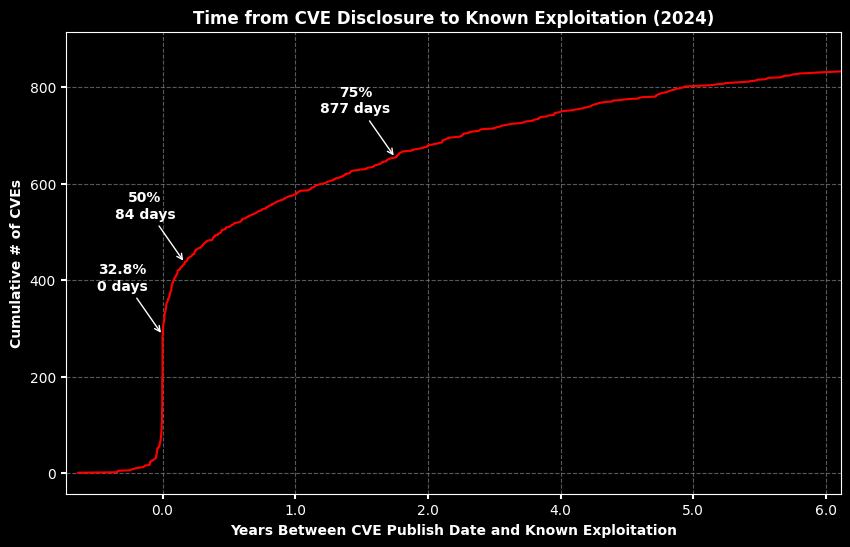

In [4]:
# Filter for rows where the VulnCheck KEV Added Date is in 2024
df_2024 = df[df['VulnCheck KEV Added Date'].dt.year == 2024].copy()

# Calculate the number of days between the two dates
df_2024.loc[:, 'Days Between'] = (df_2024['VulnCheck KEV Added Date'] - df_2024['NVD Published Date']).dt.days

# Drop rows where 'Days Between' is NaN (either date is missing)
df_2024 = df_2024.dropna(subset=['Days Between'])

# Sort by the 'Days Between' to prepare for cumulative counting
df_2024 = df_2024.sort_values(by='Days Between').reset_index(drop=True)

# Create a cumulative count of CVEs
df_2024['Cumulative CVEs'] = df_2024.index + 1

# Calculate the percentage of CVEs with 'Days Between' <= 0
percent_zero_or_less = (df_2024[df_2024['Days Between'] <= 0].shape[0] / df_2024.shape[0]) * 100
days_zero_or_less = 0  # Days for the <= 0 group

# Calculate 50% and 75% cumulative CVE count values
cve_50 = df_2024['Cumulative CVEs'].max() * 0.50
cve_75 = df_2024['Cumulative CVEs'].max() * 0.75

# Find the corresponding day values closest to these cumulative markers
days_50 = df_2024[df_2024['Cumulative CVEs'] >= cve_50].iloc[0]['Days Between']
days_75 = df_2024[df_2024['Cumulative CVEs'] >= cve_75].iloc[0]['Days Between']

# Set up dark mode for the plot
plt.style.use('dark_background')

# Plot the cumulative count with x-axis based on days, but labels as years
plt.figure(figsize=(10, 6))
plt.plot(df_2024['Days Between'], df_2024['Cumulative CVEs'], linestyle='-', color='red')

# Customize x-axis to show labels in years
plt.gca().xaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f'{x // 365}'))

# Limit x-axis to 8 years, starting at -1 year (approximately -365 to 2555 days)
plt.xlim(-365, 2555)
plt.xlabel('Years Between CVE Publish Date and Known Exploitation', color='white', fontweight='bold')
plt.ylabel('Cumulative # of CVEs', color='white', fontweight='bold')
plt.title('Time from CVE Disclosure to Known Exploitation (2024)', color='white', fontweight='bold')

# Define annotations for "25%" (<= 0 days), 50%, and 75%
annotations = [
    (days_zero_or_less, df_2024[df_2024['Days Between'] <= 0].shape[0],
     f'{percent_zero_or_less:.1f}%\n{int(days_zero_or_less)} days', 'white'),
    (days_50, cve_50, f'50%\n{int(days_50)} days', 'white'),
    (days_75, cve_75, f'75%\n{int(days_75)} days', 'white')
]

# Add annotations with arrows, offsetting to the left with shorter arrows
for days, cve, label, color in annotations:
    plt.annotate(
        f'{label}',
        xy=(days, cve),
        xytext=(days - 150, cve + 0.1 * df_2024['Cumulative CVEs'].max()),
        textcoords='data',
        arrowprops=dict(arrowstyle="->", color=color, lw=1),
        ha='center', va='bottom',
        fontsize=10, color=color, fontweight='bold'
    )

# Customize grid and tick colors for better visibility on a dark background
plt.grid(True, color='gray', linestyle='--', alpha=0.7)
plt.tick_params(colors='white', labelsize=10, width=1.5)

plt.show()


## 2025 Time from CVE disclosure to Exploitation

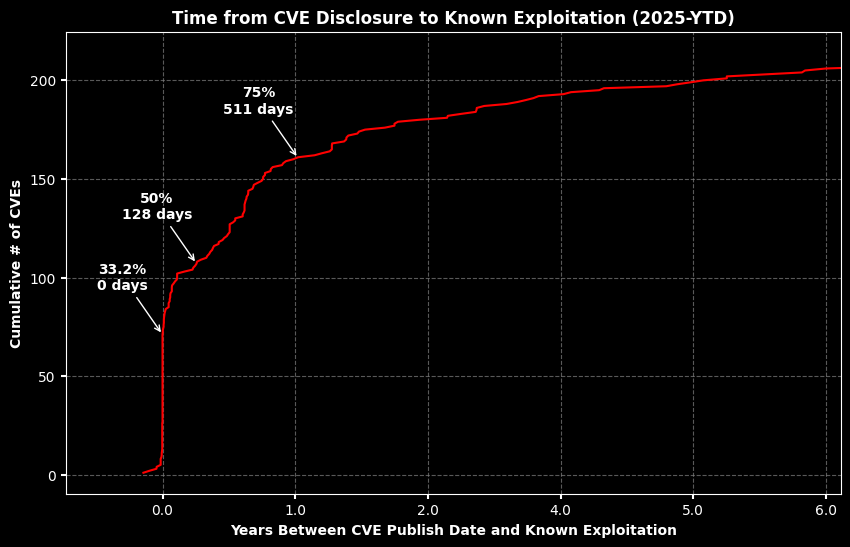

In [5]:
# Filter for rows where the VulnCheck KEV Added Date is in 2025
df_2025 = df[df['VulnCheck KEV Added Date'].dt.year == 2025].copy()

# Calculate the number of days between the two dates
df_2025.loc[:, 'Days Between'] = (df_2025['VulnCheck KEV Added Date'] - df_2025['NVD Published Date']).dt.days

# Drop rows where 'Days Between' is NaN (either date is missing)
df_2025 = df_2025.dropna(subset=['Days Between'])

# Sort by the 'Days Between' to prepare for cumulative counting
df_2025 = df_2025.sort_values(by='Days Between').reset_index(drop=True)

# Create a cumulative count of CVEs
df_2025['Cumulative CVEs'] = df_2025.index + 1

# Calculate the percentage of CVEs with 'Days Between' <= 0
percent_zero_or_less = (df_2025[df_2025['Days Between'] <= 0].shape[0] / df_2025.shape[0]) * 100
days_zero_or_less = 0  # Days for the <= 0 group

# Calculate 50% and 75% cumulative CVE count values
cve_50 = df_2025['Cumulative CVEs'].max() * 0.50
cve_75 = df_2025['Cumulative CVEs'].max() * 0.75

# Find the corresponding day values closest to these cumulative markers
days_50 = df_2025[df_2025['Cumulative CVEs'] >= cve_50].iloc[0]['Days Between']
days_75 = df_2025[df_2025['Cumulative CVEs'] >= cve_75].iloc[0]['Days Between']

# Set up dark mode for the plot
plt.style.use('dark_background')

# Plot the cumulative count with x-axis based on days, but labels as years
plt.figure(figsize=(10, 6))
plt.plot(df_2025['Days Between'], df_2025['Cumulative CVEs'], linestyle='-', color='red')

# Customize x-axis to show labels in years
plt.gca().xaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f'{x // 365}'))

# Limit x-axis to 8 years, starting at -1 year (approximately -365 to 2555 days)
plt.xlim(-365, 2555)
plt.xlabel('Years Between CVE Publish Date and Known Exploitation', color='white', fontweight='bold')
plt.ylabel('Cumulative # of CVEs', color='white', fontweight='bold')
plt.title('Time from CVE Disclosure to Known Exploitation (2025-YTD)', color='white', fontweight='bold')

# Define annotations for "25%" (<= 0 days), 50%, and 75%
annotations = [
    (days_zero_or_less, df_2025[df_2025['Days Between'] <= 0].shape[0],
     f'{percent_zero_or_less:.1f}%\n{int(days_zero_or_less)} days', 'white'),
    (days_50, cve_50, f'50%\n{int(days_50)} days', 'white'),
    (days_75, cve_75, f'75%\n{int(days_75)} days', 'white')
]

# Add annotations with arrows, offsetting to the left with shorter arrows
for days, cve, label, color in annotations:
    plt.annotate(
        f'{label}',
        xy=(days, cve),
        xytext=(days - 150, cve + 0.1 * df_2025['Cumulative CVEs'].max()),
        textcoords='data',
        arrowprops=dict(arrowstyle="->", color=color, lw=1),
        ha='center', va='bottom',
        fontsize=10, color=color, fontweight='bold'
    )

# Customize grid and tick colors for better visibility on a dark background
plt.grid(True, color='gray', linestyle='--', alpha=0.7)
plt.tick_params(colors='white', labelsize=10, width=1.5)

plt.show()

## 2023/2024 Time from CVE disclosure to Exploitation

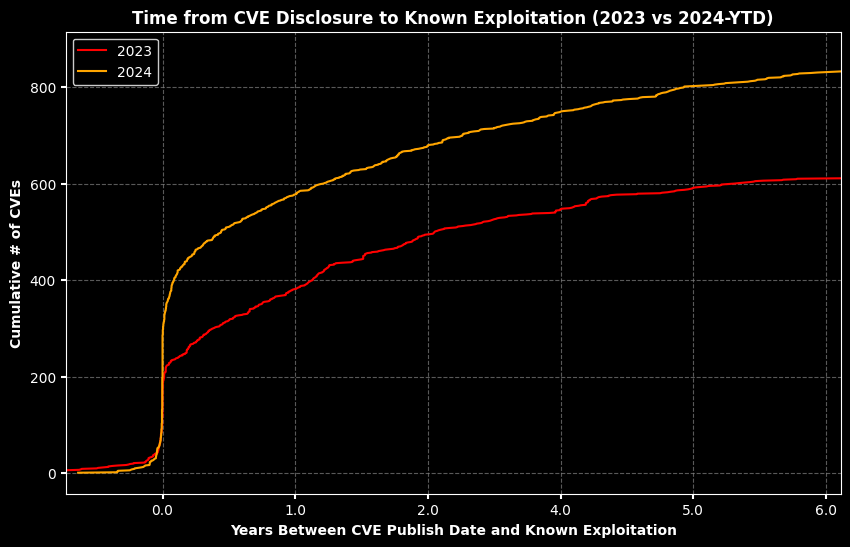

In [6]:
# Filter for rows where the VulnCheck KEV Added Date is in 2023
df_2023 = df[df['VulnCheck KEV Added Date'].dt.year == 2023].copy()
df_2023.loc[:, 'Days Between'] = (df_2023['VulnCheck KEV Added Date'] - df_2023['NVD Published Date']).dt.days
df_2023 = df_2023.dropna(subset=['Days Between']).sort_values(by='Days Between').reset_index(drop=True)
df_2023['Cumulative CVEs'] = df_2023.index + 1

# Filter for rows where the VulnCheck KEV Added Date is in 2024
df_2024 = df[df['VulnCheck KEV Added Date'].dt.year == 2024].copy()
df_2024.loc[:, 'Days Between'] = (df_2024['VulnCheck KEV Added Date'] - df_2024['NVD Published Date']).dt.days
df_2024 = df_2024.dropna(subset=['Days Between']).sort_values(by='Days Between').reset_index(drop=True)
df_2024['Cumulative CVEs'] = df_2024.index + 1

# Set up dark mode for the plot
plt.style.use('dark_background')
plt.figure(figsize=(10, 6))

# Plot the cumulative counts for 2023 and 2024
plt.plot(df_2023['Days Between'], df_2023['Cumulative CVEs'], linestyle='-', color='red', label='2023')
plt.plot(df_2024['Days Between'], df_2024['Cumulative CVEs'], linestyle='-', color='orange', label='2024')

# Customize x-axis to show labels in years
plt.gca().xaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f'{x // 365}'))

# Limit x-axis to 8 years, starting at -1 year (approximately -365 to 2555 days)
plt.xlim(-365, 2555)
plt.xlabel('Years Between CVE Publish Date and Known Exploitation', color='white', fontweight='bold')
plt.ylabel('Cumulative # of CVEs', color='white', fontweight='bold')
plt.title('Time from CVE Disclosure to Known Exploitation (2023 vs 2024-YTD)', color='white', fontweight='bold')

# Add a legend
plt.legend(loc='upper left', fontsize=10, facecolor='black', edgecolor='white', framealpha=0.8)

# Customize grid and tick colors for better visibility on a dark background
plt.grid(True, color='gray', linestyle='--', alpha=0.7)
plt.tick_params(colors='white', labelsize=10, width=1.5)

# Show the plot
plt.show()
